<a href="https://colab.research.google.com/github/amplabs-ai/amplabs/blob/main/MRS_Sandia_AmpLabs_Example_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MRS - Sandia AmpLabs Example 3






In this demo you will learn how to:

1. Fetch battery data from **AmpLabs JSON API**
2. Define new metrics and add them as new corresponding columns using **Pandas**
3. Plot graphs using **Matplotlib**


We will use the following Python libraries and tools

**Pandas** is an easy-to-use data structures and data analysis tools for the Python programming language. In Pandas, we can import data from various file formats like JSON, SQL, Microsoft Excel, etc. When working with tabular data, such as data stored in spreadsheets or databases, pandas will help you to explore, clean, and process your data. In pandas, a data table is called a **Data Frame**.

Note: Pandas is built off of another library called **NumPy**. 

**Matplotlib** Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.



In [ ]:
# Mount Google Drive 

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install necessary libraries


In [ ]:
# Download python packages to your system using pip install
import sys
!{sys.executable} -m pip install pandas scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the libraries we downloaded into the Python environment


In [ ]:
# Useful for fetching data from the web 

import json
import urllib.error
import urllib.request

# PyData Libraries

import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

# Library useful for rendering Images and suppressing warnings in Jupyter Notebooks

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

# Define Helper Function

In [ ]:
def get_amplabs_data(cell_id):
    url = "https://www.amplabs.ai/download/cells/cycle_data_json?cell_id={}".format(cell_id.replace('/', '%2F'))
    user_token = "<token>"
    httprequest = urllib.request.Request(
            url, method="GET"
            )
    httprequest.add_header("Authorization", "Bearer {}".format(user_token))

    try:
        with urllib.request.urlopen(httprequest) as httpresponse:
            response = json.loads(httpresponse.read())
            return response
    except urllib.error.HTTPError as e:
        print(e)
    return None


In [ ]:
#Fetch Data from Amplabs API
cell_id = "SNL_18650_LFP_25C_0-100_0.5/1C_a"
response = get_amplabs_data(cell_id)

df_cell = pd.DataFrame(response['records'][0])

print("Process complete", df_cell.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3544 entries, 0 to 3543
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Charge_Capacity (Ah)     3544 non-null   float64
 1   Charge_Energy (Wh)       3544 non-null   float64
 2   Cycle_Index              3544 non-null   int64  
 3   Discharge_Capacity (Ah)  3544 non-null   float64
 4   Discharge_Energy (Wh)    3544 non-null   float64
 5   End_Time                 0 non-null      object 
 6   Max_Current (A)          3544 non-null   float64
 7   Max_Voltage (V)          3544 non-null   float64
 8   Min_Current (A)          3544 non-null   float64
 9   Min_Voltage (V)          3544 non-null   float64
 10  Start_Time               0 non-null      object 
 11  Test_Time (s)            3544 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 332.4+ KB
Process complete None


In [ ]:
file_name = '/content/drive/MyDrive/MRS/Gr-LFP_127662duty.mat'

# import data from the Matlab .mat file
# scipy converts the mat struct in a Python struct
data_scipy = scipy.io.loadmat(file_name)
data_scipy.keys()

In [ ]:
for key in data_scipy:
  print(key, type(data_scipy[key]))

__header__ <class 'bytes'>
__version__ <class 'str'>
__globals__ <class 'list'>
LAMNEeq <class 'numpy.ndarray'>
LAMPEeq <class 'numpy.ndarray'>
LLIeq <class 'numpy.ndarray'>
QL <class 'numpy.ndarray'>
Vi <class 'numpy.ndarray'>
cyc <class 'numpy.ndarray'>
key <class 'numpy.ndarray'>
p1 <class 'numpy.ndarray'>
p2 <class 'numpy.ndarray'>
p3 <class 'numpy.ndarray'>
p4 <class 'numpy.ndarray'>
p5 <class 'numpy.ndarray'>
p6 <class 'numpy.ndarray'>
p7 <class 'numpy.ndarray'>
p8 <class 'numpy.ndarray'>


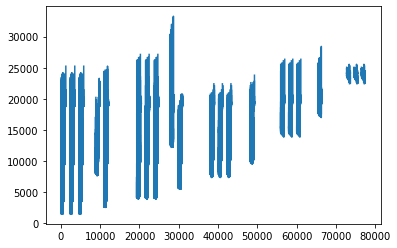

In [ ]:
# Calculate the normalized capacity
# Ensure that the data is converted to numeric values
df_cell['Discharge_Capacity (Ah)'] = pd.to_numeric(df_cell['Discharge_Capacity (Ah)'])

# Normalize the capacity using the initial cell capacity
df_cell['Ah_loss'] = 100.0*(df_cell['Discharge_Capacity (Ah)'])/df_cell['Discharge_Capacity (Ah)'].iloc[0]

# Switch from capacity loss to capacity remaining
QL = 100.0 - data_scipy['QL']

# Import the degradation components
LAMNEeq = data_scipy['LAMNEeq']
LAMPEeq = data_scipy['LAMPEeq']
LLIeq = data_scipy['LLIeq']
cyc = data_scipy['cyc']

#Experimental data start from 1, not 0. We are assuming cycle 1 of the experiments is equivalent to cycle 0 of the synthetic data
cyc[0, 0] = 1

# filter cell data by the cycles available in the Matlab database
df_cell_ah_loss = df_cell[df_cell.Cycle_Index.isin(cyc[0])]

# move to arrays to calculate min squared error
Ah_loss = df_cell_ah_loss['Ah_loss'].to_numpy()

# Calculate all the residuals -- this is how to work directly with arrays elements

delta = []

j = 0

for x in QL:

    i = 0
    delta_v = 0

    for k in x:
        delta_v += (k-Ah_loss[i])**2
        i += 1

    delta.append(delta_v)

# Plot the residuals
plt.plot(delta)

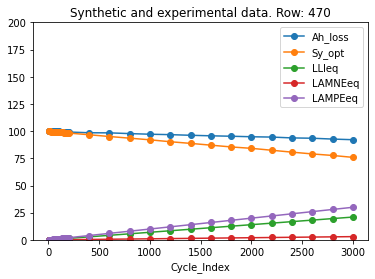

In [ ]:
# find the minimum error and the corresponding index
min_value = min(delta)
min_index = delta.index(min_value)

# Collect all the info in one dataframe
df_cell_ah_loss['LLIeq'] = LLIeq[min_index].transpose()
df_cell_ah_loss['LAMNEeq'] = LAMNEeq[min_index].transpose()
df_cell_ah_loss['LAMPEeq'] = LAMPEeq[min_index].transpose()
df_cell_ah_loss['Sy_opt'] = QL[min_index].transpose()


# Plot synthetic and experimental data
df_cell_ah_loss.plot(x='Cycle_Index', y=["Ah_loss", "Sy_opt", "LLIeq", "LAMNEeq", "LAMPEeq"], marker="o")
plt.title('Synthetic and experimental data. Row: ' + str(min_index))
plt.xlabel('Cycle_Index')
plt.ylim([0, 200])
plt.legend()
plt.show()